In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import models
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F

In [2]:
from src import display
from src import data_transformer as dt
from src.evaluation import jaccard, non_max_suppression, PredBoundingBox, MAP

In [3]:
from sklearn.metrics import average_precision_score
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [4]:
img_path = "data/VOCdevkit/VOC2012/JPEGImages/"
train_json_path = "data/pascal_train2012.json"

In [5]:
target_size = 224

seed = 42
device = "cuda"

In [6]:
id_cat, train_list = dt.load_pascal(train_json_path)

In [7]:
train_list = dt.rescale_bounding_boxes(train_list, target_size)
train_list = dt.convert_to_center(train_list)

In [8]:
example = train_list[0]
example

ImageEntry(filename='2008_000008.jpg', width=500, height=442, classnames=['horse', 'person'], class_id=[12, 14], bounding_boxes=[[117.0, 128.5, 188, 169], [99.5, 53.5, 59, 63]])

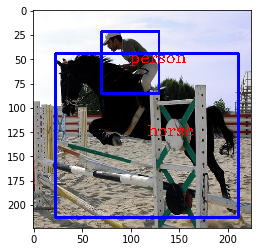

In [9]:
img_str = img_path + example.filename
img = display.read_img(img_str, target_size)

img = display.draw_boxes(img, example.bounding_boxes)
img = display.draw_text(img, example.classnames, example.bounding_boxes)
plt.imshow(img)
plt.show()

In [10]:
anchor_grid = [4, 2, 1] # Number of grid-elements per dimension
anchor_zooms = [0.7, 1.0, 1.3] # How much bigger/smaller each default box will be (percentage)
anchor_ratios = [(1.0, 1.0), (1.0, 0.5), (0.5, 1.0)] # Ratio between (width, height)

anchor_scales = [(anc*h, anc*w) for anc in anchor_zooms for (h,w) in anchor_ratios]
anchor_offsets = [1/(2*o) for o in anchor_grid]
num_boxes = len(anchor_scales)

In [11]:
anchor_x = [np.repeat(np.linspace(ao, 1-ao, ag), ag) for (ao, ag) in zip(anchor_offsets, anchor_grid)]
anchor_x = np.concatenate(anchor_x)

anchor_y = [np.tile(np.linspace(ao, 1-ao, ag), ag) for ao,ag in zip(anchor_offsets, anchor_grid)]
anchor_y = np.concatenate(anchor_y)

anchor_centers = np.repeat(np.stack([anchor_x, anchor_y], axis=1), num_boxes, axis=0)

In [12]:
anchor_sizes  = [np.array([[w/ag, h/ag] for _ in range(ag**2) for w, h in anchor_scales])
                 for ag in anchor_grid]
anchor_sizes = np.concatenate(anchor_sizes)

anchors = np.concatenate([anchor_centers, anchor_sizes], axis=1)
anchors = torch.from_numpy(anchors).float()
anchors = anchors.to(device)

In [13]:
ground_truths = []
classes = []

for item in train_list:
    gt = np.vstack(item.bounding_boxes)
    gt = torch.from_numpy(gt).float() / target_size
    ground_truths.append(gt[None, :, :].to(device))

    # Adding +1 since first element should be background
    c = torch.from_numpy(np.array(item.class_id)) + 1
    classes.append(c[None, :].to(device))

In [14]:
def flatten_conv(x, num_boxes):
    samples, channels, _, _ = x.size()
    x = x.permute(0, 2, 3, 1).contiguous()
    return x.view(samples, -1, int(channels/num_boxes))

class StandardConv(nn.Module):
    def __init__(self, in_channels, out_channels, stride=2):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.conv(x)
        x = F.relu(x)
        x = self.bn(x)
        return x

class UpsampleModule(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.conv_2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x, x_upsample):
        x = F.interpolate(x_upsample, scale_factor=2, mode="nearest") + self.conv_1(x)
        x = self.conv_2(x)
        return x
    
class FPN(nn.Module):
    def __init__(self):
        super().__init__()

        pretrained_model = list(models.vgg16(pretrained='imagenet').children())[:-1]
        self.pretrained_model = nn.Sequential(*pretrained_model)

        self.std_conv_1 = StandardConv(512, 256, stride=1)
        self.std_conv_2 = StandardConv(256, 256)
        self.std_conv_3 = StandardConv(256, 256)
        self.std_conv_4 = StandardConv(256, 256)

        self.upsample_1 = UpsampleModule(256, 256)
        self.upsample_2 = UpsampleModule(256, 256)

    def forward(self, x):
        x = self.pretrained_model(x)
        x = F.relu(x)
        x = self.std_conv_1(x)
        x4 = self.std_conv_2(x)
        x2 = self.std_conv_3(x4)
        x1 = self.std_conv_4(x2)

        x_upsample_1 = self.upsample_1(x2, x1)
        x_upsample_2 = self.upsample_2(x4, x_upsample_1)

        return (x_upsample_2, x_upsample_1, x1)

    def change_freezing(self, mode=False):
        for param in self.pretrained_model.parameters():
            param.requires_grad = mode

class RegressionHead(nn.Module):
    def __init__(self, num_boxes, num_channels=256):
        super().__init__()
        self.num_boxes = num_boxes

        self.conv_1 = nn.Conv2d(num_channels, num_channels, kernel_size=3, stride=1, padding=1)
        self.conv_2 = nn.Conv2d(num_channels, num_channels, kernel_size=3, stride=1, padding=1)
        self.conv_3 = nn.Conv2d(num_channels, num_channels, kernel_size=3, stride=1, padding=1)
        self.conv_4 = nn.Conv2d(num_channels, num_channels, kernel_size=3, stride=1, padding=1)
        self.conv_out = nn.Conv2d(num_channels, 4*num_boxes, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.conv_1(x)
        x = F.relu(x)

        x = self.conv_2(x)
        x = F.relu(x)

        x = self.conv_3(x)
        x = F.relu(x)

        x = self.conv_4(x)
        x = F.relu(x)

        x = self.conv_out(x)
        return flatten_conv(x, self.num_boxes)

class ClassificationHead(nn.Module):
    def __init__(self, num_boxes, num_channels=256):
        super().__init__()
        self.num_boxes = num_boxes

        self.conv_1 = nn.Conv2d(num_channels, num_channels, kernel_size=3, stride=1, padding=1)
        self.conv_2 = nn.Conv2d(num_channels, num_channels, kernel_size=3, stride=1, padding=1)
        self.conv_3 = nn.Conv2d(num_channels, num_channels, kernel_size=3, stride=1, padding=1)
        self.conv_4 = nn.Conv2d(num_channels, num_channels, kernel_size=3, stride=1, padding=1)
        self.conv_out = nn.Conv2d(num_channels, (len(id_cat)+1)*num_boxes, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.conv_1(x)
        x = F.relu(x)

        x = self.conv_2(x)
        x = F.relu(x)

        x = self.conv_3(x)
        x = F.relu(x)

        x = self.conv_4(x)
        x = F.relu(x)

        x = self.conv_out(x)
        return flatten_conv(x, self.num_boxes)

class RetinaNet(nn.Module):
    def __init__(self, num_boxes):
        super().__init__()
        self.fpn = FPN()
        self.fpn.change_freezing(False)

        self.reg = RegressionHead(num_boxes)
        self.classification = ClassificationHead(num_boxes)

    def forward(self, x):
        fpn_out = self.fpn(x)
        
        return [torch.cat([self.classification(fpn_out[0]),
                           self.classification(fpn_out[1]),
                           self.classification(fpn_out[2])],
                          dim=1),
                torch.cat([self.reg(fpn_out[0]),
                           self.reg(fpn_out[1]),
                           self.reg(fpn_out[2])],
                          dim=1)       
               ]

In [15]:
class PascalData(Dataset):
    def __init__(self, data_list, ground_truths, classes, target_size=target_size, path=img_path):
        self.target_size = target_size
        self.path = path

        self.file_list = [i.filename for i in data_list]
        self.ground_truths = ground_truths
        self.classes = classes

        self.mean = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
        self.std = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_str = self.path + self.file_list[idx]

        img = display.read_img(img_str, self.target_size)
        img = img / 255.0
        img = img.transpose((2, 0, 1))
        img = (img - self.mean) / self.std
        img = torch.from_numpy(img).float().to(device)

        return (img, self.ground_truths[idx], self.classes[idx])

def collate_fn(batch):
    """
    Writing custom collector function since the Dataset class returns both tensors and lists.
    """

    x = [b[0] for b in batch]
    x = torch.stack(x, dim=0)
    gt = [b[1] for b in batch]
    c = [b[2] for b in batch]
    return (x, gt, c)

In [16]:
def find_overlap(bb_true_i, anchors, jaccard_overlap):
    jaccard_tensor = jaccard(anchors, bb_true_i)
    _, max_overlap = torch.max(jaccard_tensor, dim=0)
    
    overlap_list = []    
    for i in range(len(bb_true_i)):
        threshold_overlap = (jaccard_tensor[:, i] > jaccard_overlap).nonzero()

        if len(threshold_overlap) > 0:
            threshold_overlap = threshold_overlap[:, 0]
            overlap = torch.cat([max_overlap[i].view(1), threshold_overlap])
            overlap = torch.unique(overlap)     
        else:
            overlap = max_overlap[i].view(1)
        overlap_list.append(overlap)
    return overlap_list

In [17]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2, device="cuda", eps=1e-10):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.device = device
        self.eps = eps

    def forward(self, input, target):
        p = torch.sigmoid(input)
        pt = p * target.float() + (1.0 - p) * (1 - target).float()
        alpha_t = (1.0 - self.alpha) * target.float() + self.alpha * (1 - target).float()
        loss = - 1.0 * torch.pow((1 - pt), self.gamma) * torch.log(pt + self.eps)
        return loss.sum()

In [18]:
class Loss(nn.Module):
    def __init__(self, loc_factor, anchors, jaccard_overlap, **kwargs):
        super().__init__()
        self.fl = FocalLoss(**kwargs)
        self.loc_factor = loc_factor
        self.jaccard_overlap = jaccard_overlap
        self.anchors = anchors

    @staticmethod
    def one_hot_encoding(labels, num_classes):
        return torch.eye(num_classes)[labels]

    @staticmethod
    def loc_transformation(x, anchors, overlap_indicies):
        # Doing location transformations according to SSD paper
        return torch.cat([(x[:, 0:1] - anchors[overlap_indicies, 0:1]) / anchors[overlap_indicies, 2:3],
                          (x[:, 1:2] - anchors[overlap_indicies, 1:2]) / anchors[overlap_indicies, 3:4],
                          torch.log((x[:, 2:3] / anchors[overlap_indicies, 2:3])),
                          torch.log((x[:, 3:4] / anchors[overlap_indicies, 3:4]))
                         ], dim=1)

    def forward(self, class_hat, bb_hat, class_true, bb_true):        
        loc_loss = 0.0
        class_loss = 0.0

        for i in range(len(class_true)):  # Batch level
            class_hat_i = class_hat[i, :, :]
            bb_true_i = bb_true[i]
            class_true_i = class_true[i]
            class_target = torch.zeros(class_hat_i.shape[0]).long().to(device)

            overlap_list = find_overlap(bb_true_i.squeeze(0), self.anchors, self.jaccard_overlap)

            temp_loc_loss = 0.0
            for j in range(len(overlap_list)):  # BB level
                overlap = overlap_list[j]
                class_target[overlap] = class_true_i[0, j]

                input_ = bb_hat[i, overlap, :]
                target_ = Loss.loc_transformation(bb_true_i[0, j, :].expand((len(overlap), 4)), self.anchors, overlap)

                temp_loc_loss += F.smooth_l1_loss(input=input_, target=target_, reduction="sum") / len(overlap)
            loc_loss += temp_loc_loss / class_true_i.shape[1]

            class_target = Loss.one_hot_encoding(class_target, len(id_cat) + 1).float().to(device)
            class_loss += self.fl(class_hat_i, class_target) / class_true_i.shape[1]

        loc_loss = loc_loss / len(class_true)
        class_loss = class_loss / len(class_true)
        loss = class_loss + loc_loss * self.loc_factor

        return loss, loc_loss, class_loss

In [19]:
loss = Loss(loc_factor=5.0, anchors=anchors, jaccard_overlap=0.4)

In [20]:
torch.manual_seed(seed)
model = RetinaNet(num_boxes=num_boxes).to(device)

In [21]:
batch_size = 64
train_dataset = PascalData(train_list, ground_truths, classes)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=collate_fn)

In [22]:
n_epochs = 40
lr = 1e-4
wd = 0.0005

In [23]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=wd)

In [24]:
torch.manual_seed(seed)
for epoch in range(0, n_epochs+1):
    model.train()
    train_loss = 0.0

    loc_loss = 0.0
    class_loss = 0.0

    for _, (x, bb_true, class_true) in enumerate(train_loader):
        model.zero_grad()
        class_hat, bb_hat = model(x)

        batch_loss, batch_loc, batch_class = loss(class_hat, bb_hat, class_true, bb_true)
        batch_loss.backward()
        optimizer.step()

        class_loss += batch_class
        loc_loss += batch_loc
        train_loss += batch_loss

    train_loss = (train_loss/len(train_loader)).detach().cpu().numpy()
    loc_loss = (loc_loss/len(train_loader)).detach().cpu().numpy()
    class_loss = (class_loss/len(train_loader)).detach().cpu().numpy()

    if epoch % 5 == 0:
        print(f"----- epoch {epoch} -----")
        print("Train loss: {:.4f}".format(train_loss))
        print("Loc loss: {:.4f}".format(loc_loss))
        print("Class loss: {:.4f}".format(class_loss))

----- epoch 0 -----
Train loss: 106.3283
Loc loss: 0.2365
Class loss: 105.1459
----- epoch 5 -----
Train loss: 8.8978
Loc loss: 0.1721
Class loss: 8.0375
----- epoch 10 -----
Train loss: 7.5317
Loc loss: 0.1342
Class loss: 6.8610
----- epoch 15 -----
Train loss: 6.6860
Loc loss: 0.0938
Class loss: 6.2171
----- epoch 20 -----
Train loss: 5.7046
Loc loss: 0.0762
Class loss: 5.3236
----- epoch 25 -----
Train loss: 5.0863
Loc loss: 0.0629
Class loss: 4.7718
----- epoch 30 -----
Train loss: 4.6171
Loc loss: 0.0516
Class loss: 4.3589
----- epoch 35 -----
Train loss: 4.1767
Loc loss: 0.0445
Class loss: 3.9542
----- epoch 40 -----
Train loss: 3.7732
Loc loss: 0.0405
Class loss: 3.5708


In [46]:
background_threshold = 0.5

i = 1
(x, bb_true, class_true) = train_dataset[i]
img_file = train_dataset.file_list[i]

In [47]:
model.eval()
class_hat, bb_hat = model(x.unsqueeze(0))

bb_hat = dt.invert_transformation(bb_hat.squeeze(0), anchors)
bb_hat = bb_hat * target_size

class_hat = class_hat.sigmoid().squeeze(0)

In [48]:
# Filtering with < since we want low probability of background
bb_hat = bb_hat[class_hat[:,0] < background_threshold, :]
bb_hat = bb_hat.detach().cpu().numpy()
class_hat = class_hat[class_hat[:,0] < background_threshold, :]

In [49]:
class_preds = class_hat[:, 1:]
prob, class_id = class_preds.max(1)

prob = prob.detach().cpu().numpy()
class_id = class_id.detach().cpu().numpy()

In [50]:
output_bb = [PredBoundingBox(probability=prob[i],
                             class_id=class_id[i],
                             classname=id_cat[class_id[i]],
                             bounding_box=[bb_hat[i, 0], 
                                           bb_hat[i, 1], 
                                           bb_hat[i, 2], 
                                           bb_hat[i, 3]])
             for i in range(len(prob))]

output_bb = sorted(output_bb, key = lambda x: x.probability, reverse=True)

In [51]:
filtered_bb = non_max_suppression(output_bb)

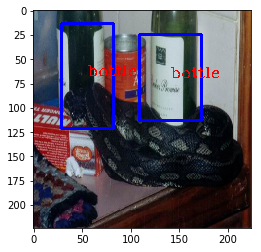

In [52]:
img_str = img_path + img_file
img = display.read_img(img_str, target_size)

img = display.read_img(img_str, target_size)
img = display.draw_boxes(img, [bb.bounding_box for bb in filtered_bb])
img = display.draw_text(img, [bb.classname for bb in filtered_bb], [bb.bounding_box for bb in filtered_bb])
plt.imshow(img)
plt.show()

In [38]:
jaccard_threshold = 0.5
num_samples = 500

map_eval = MAP(model, jaccard_threshold, anchors)
aps, mAP = map_eval(train_dataset, num_samples)
print(mAP)

0.2932745291338086
